### 通し課題1 Kickstar Ploject
Day2まで(標準化+無相関化+ロジスティック回帰+L1正則化+)の精度は以下の通り。
w0 = -0.781, w1 = -14.621, w2 = -0.044  
訓練誤差  
対数尤度 = -12.271  
正答率（Accuracy） = 64.471%  
適合率（Precision） = 67.083%  
再現率（Recall） = 79.186%  
F1値（F1-score） = 72.634%  
汎化誤差  
対数尤度 = -12.162  
正答率（Accuracy） = 64.786%  
適合率（Precision） = 67.533%  
再現率（Recall） = 79.352%  
F1値（F1-score） = 72.967%  
CVはエラー、SVMは次元が多すぎるせいか計算時間がものすごいかかって終わらないので断念。
ver1との違いはデータ数を10分の1にしてカテゴリを導入。SVMとかも試してみる。
#### 目次
#### 前回までの前処理
#### 特徴選択 
#### 木モデル
#### ニューラルネットワーク

### 前回までの前処理

In [84]:
# 必要なモジュールの読み込み
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
#Day2
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
#from common_func import plot_decision_regions
#なぜかエラー出る。day2vol5では使えてた
#Day3
from sklearn.feature_selection import RFECV, SelectFromModel
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from tensorflow.compat.v1.keras.models import load_model

In [85]:
df_ks0 = pd.read_csv("kickstarter_project/ks-projects-201801.csv")
df_ks0.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [92]:
print(df_ks0['launched'].min())

1970-01-01 01:00:00


説明変数の相関係数を表示して除外する変数を決める。
除外する説明変数を本来なら機械側で計算して決めないといけないがとりあえず人側で決める。pledged, usd pledged, usd_pledged_realは集まった金額、backersは集まった支援者を指しプロジェクト前はわからないので除外。  
IDとnameもデータの性質を表すものではないので除外。  
goalとusd_goal_realはほぼ同じ意味なので通貨を統一したusdのものを使う。  
currencyとcountryは相関係数高そう。  
開始日と終了日の間の期間も関係しているかもしれないので計算してカラムに追加。

In [96]:
#csv読み込む
df_ks = pd.read_csv("kickstarter_project/ks-projects-201801.csv")[[ 'state', 'category', 'main_category', 'currency', 'country', 'usd_goal_real', 'deadline', 'launched']]

#KSのlaunched、deadlineから開催期間(日数)を計算する
#文字列をdatetime型に変換
#df_ks['launched'] = datetime.datetime.strptime(df_ks['launched'], '%Y/%m/%d %H:%M') 
#df_ks['deadline'] = datetime.datetime.strptime(df_ks['deadline'], '%Y/%m/%d')
df_ks['launched'] = pd.to_datetime(df_ks['launched']) 
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])

#期間を計算
df_ks['delta'] = (df_ks['deadline'] - df_ks['launched']).apply(lambda x: x.days)
#こっちだとエラー出た
#df_ks['delta'] = datetime.datetime.strptime(df_ks['launched'], '%d %H:%M:%S')
#.apply(~がないとerror起こす。配列には適用できない？
#print(df_ks['delta'].days)


#launch, deadline削除
#df_ks = df_ks.drop(columns=['launched', 'deadline'])
#category削除
#df_ks = df_ks.drop(columns=['category'])


#欠損値がないか確認
print(df_ks.isnull().sum())
print(df_ks.notnull().sum())

state            0
category         0
main_category    0
currency         0
country          0
usd_goal_real    0
deadline         0
launched         0
delta            0
dtype: int64
state            378661
category         378661
main_category    378661
currency         378661
country          378661
usd_goal_real    378661
deadline         378661
launched         378661
delta            378661
dtype: int64


今回作りたいのは成功するか失敗するかを予測するモデル。  
したがってstateの教師データとして使えるのはsuccessfulとfailed。それ以外は除外。

In [97]:
print(df_ks['state'].unique())

#stateがsuccessfulとfailed以外のもの削除
df_ks = df_ks.query('state == ["successful", "failed"]')

#stateの列を数字に置き換え(failedを0、successfulを1)
for df in [df_ks]:    
    df.loc[df['state']=='failed', "state"]=0
    df.loc[df['state']=='successful', "state"]=1

print(df_ks.head())

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
   state        category main_category currency country  usd_goal_real  \
0      0          Poetry    Publishing      GBP      GB        1533.95   
1      0  Narrative Film  Film & Video      USD      US       30000.00   
2      0  Narrative Film  Film & Video      USD      US       45000.00   
3      0           Music         Music      USD      US        5000.00   
5      1     Restaurants          Food      USD      US       50000.00   

    deadline            launched  delta  
0 2015-10-09 2015-08-11 12:12:28     58  
1 2017-11-01 2017-09-02 04:43:57     59  
2 2013-02-26 2013-01-12 00:20:50     44  
3 2012-04-16 2012-03-17 03:24:11     29  
5 2016-04-01 2016-02-26 13:38:27     34  


In [98]:
print(df_ks.dtypes) #データ型確認

state                     int64
category                 object
main_category            object
currency                 object
country                  object
usd_goal_real           float64
deadline         datetime64[ns]
launched         datetime64[ns]
delta                     int64
dtype: object


In [99]:
print(df_ks['launched'].min())

2009-04-21 21:02:48


In [100]:
df_ks.shape

(331675, 9)

2009-04-21 21:02:48
   state        category main_category currency country  usd_goal_real  \
0      0          Poetry    Publishing      GBP      GB        1533.95   
1      0  Narrative Film  Film & Video      USD      US       30000.00   
2      0  Narrative Film  Film & Video      USD      US       45000.00   
3      0           Music         Music      USD      US        5000.00   
5      1     Restaurants          Food      USD      US       50000.00   

   launched  delta  
0      2015     58  
1      2017     59  
2      2013     44  
3      2012     29  
5      2016     34  


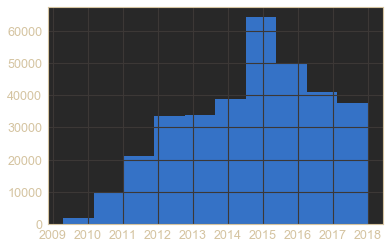

In [66]:
#launchedを年別にカテゴリ化
#launchedの分布
data = df_ks['launched']
plt.hist(data);

#要素ごとの場合print(df_ks['launched'][0].year)
df_ks['launched']= df_ks['launched'].dt.year
#deadline削除
df_ks = df_ks.drop(columns=['deadline'])
print(df_ks.head())

count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64
5000.00      21454
10000.00     18351
1000.00      11908
3000.00      11474
2000.00      10815
15000.00     10028
2500.00       8910
20000.00      8803
500.00        7935
1500.00       7413
25000.00      7251
50000.00      6026
4000.00       6024
6000.00       5352
3500.00       5154
30000.00      5029
8000.00       4597
7000.00       3681
7500.00       3629
12000.00      3629
100000.00     2784
35000.00      2284
1200.00       2254
5500.00       2119
4500.00       2079
40000.00      2078
300.00        2055
600.00        1932
800.00        1745
6500.00       1694
             ...  
1490.25          1
28760.00         1
1530.46          1
182684.55        1
59124.29         1
957.30           1
15175.11         1
1465.00          1
165502.02        1
1160.63          1
247240.18

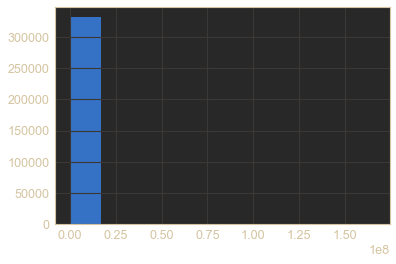

In [67]:
data = df_ks['usd_goal_real']
print(data.describe())
plt.hist(data);
print(data.value_counts())

上記は目標額(usd_goal_real)のヒストグラム。ほとんどが1000万以下で外れ値が1.6億までのスケールで存在していることがわかる。

In [8]:
#度数分布表
# スタージェスの公式（Sturges' formula）から階級の数を求める
from math import log
class_size = 1 + log(len(data), 2)
print(class_size)
#19.339410747535684
#よって階級の数は20

# 階級幅を求める
#-----
class_width =(max(data)-min(data))/20 #分母は階級の数、分子は範囲。
print(class_width)
#8318069.535000001
#よって階級幅は832万

# 階級に振り分ける
#各観測値を階級値にする
def Frequency_Distribution(data, class_width):
    cut_data = []
    for row in data:
        cut = row // class_width
        cut_data.append(cut)
    return cut_data

#頻度を数える
Frequency_data = pd.Series(Frequency_Distribution(data, class_width)).value_counts()
print('インデックスは832万で1段階')
print(Frequency_data.sort_index())
#indexが15個しかない。飛び値があるからか？

19.339410747535684
8318069.535000001
インデックスは832万で1段階
0.0     331515
1.0         70
2.0         24
3.0         13
4.0          5
5.0          2
6.0         14
7.0          1
8.0          1
9.0          4
10.0         2
12.0        21
13.0         1
18.0         1
20.0         1
dtype: int64


In [9]:
class_width =(max(data)-min(data))/100 #分母は階級の数、分子は範囲。
print(class_width)
#8318069.535000001
#よって階級幅は832万

# 階級に振り分ける
#各観測値を階級値にする
def Frequency_Distribution(data, class_width):
    cut_data = []
    for row in data:
        cut = row // class_width
        cut_data.append(cut)
    return cut_data

#頻度を数える
Frequency_data = pd.Series(Frequency_Distribution(data, class_width)).value_counts()
print('インデックスは83万で1段階.さきほどより10倍細かくした')
print(Frequency_data.sort_index())
#indexが15個しかない。飛び値があるからか？

1663613.9070000001
インデックスは83万で1段階.さきほどより10倍細かくした
0.0      331096
1.0         271
2.0          48
3.0          78
4.0          22
5.0          14
6.0          41
7.0           4
8.0           3
9.0           8
10.0          3
11.0          1
12.0         12
13.0          5
14.0          3
15.0          7
17.0          2
18.0          3
19.0          1
21.0          2
23.0          1
24.0          2
26.0          1
27.0          1
30.0         10
31.0          1
33.0          2
34.0          1
36.0          1
43.0          1
45.0          1
47.0          1
48.0          1
49.0          1
50.0          1
52.0          1
60.0         19
62.0          1
64.0          1
66.0          1
91.0          1
100.0         1
dtype: int64


上記はusd_goal_realの度数分布表。100万以上は全体の10%以下なので外れ値とみなし除外する。

count     330835.000000
mean       18920.450247
std        56353.350048
min            0.010000
25%         2000.000000
50%         5000.000000
75%        15000.000000
max      1000000.000000
Name: usd_goal_real, dtype: float64


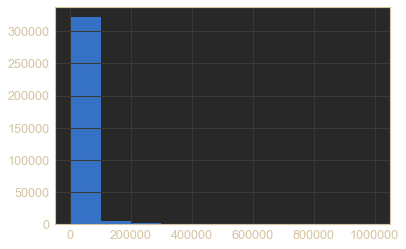

In [10]:
df_ks = df_ks[df_ks['usd_goal_real'] < 1000001]
data = df_ks['usd_goal_real']
print(data.describe()) #maxが1000万になっている
plt.hist(data);

state,0,1
category,,
Product Design,10706,7962
Documentary,8571,5924
Music,6184,6432
Tabletop Games,3876,7866
Shorts,4716,6673
Food,7108,3297
Video Games,6911,2380
Film & Video,5471,3070
Fiction,5873,2233


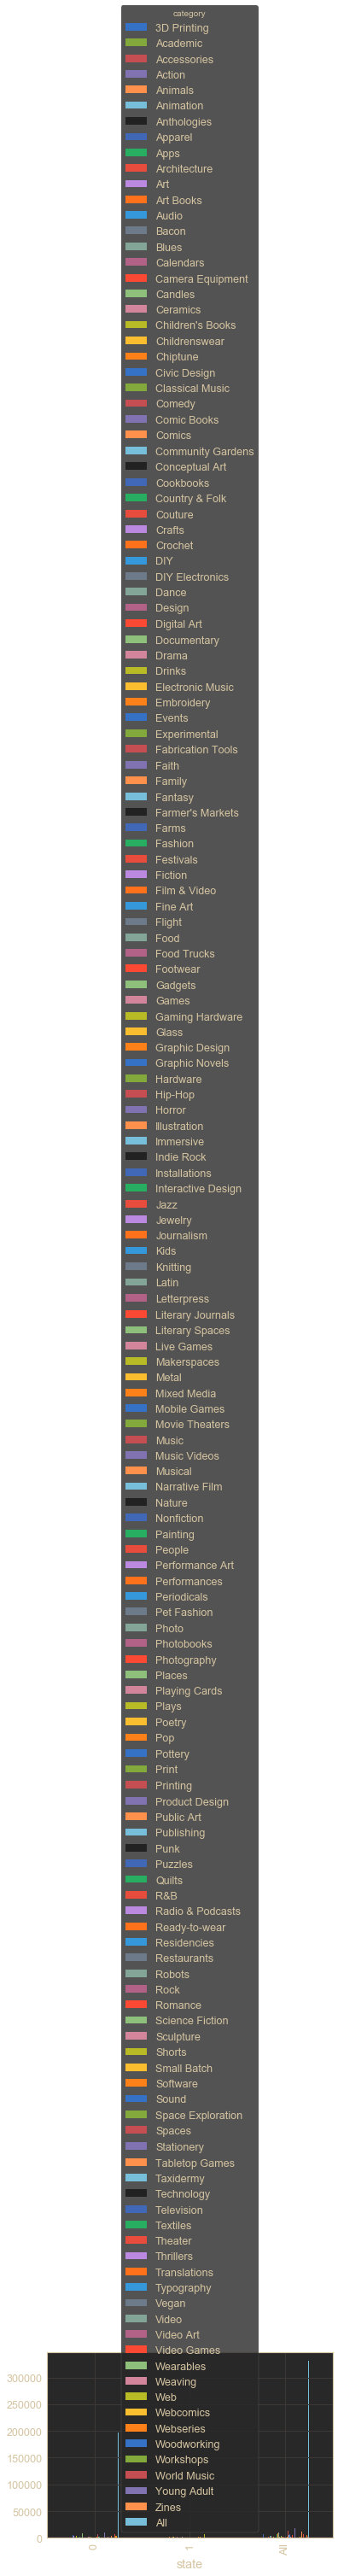

<Figure size 1080x720 with 0 Axes>

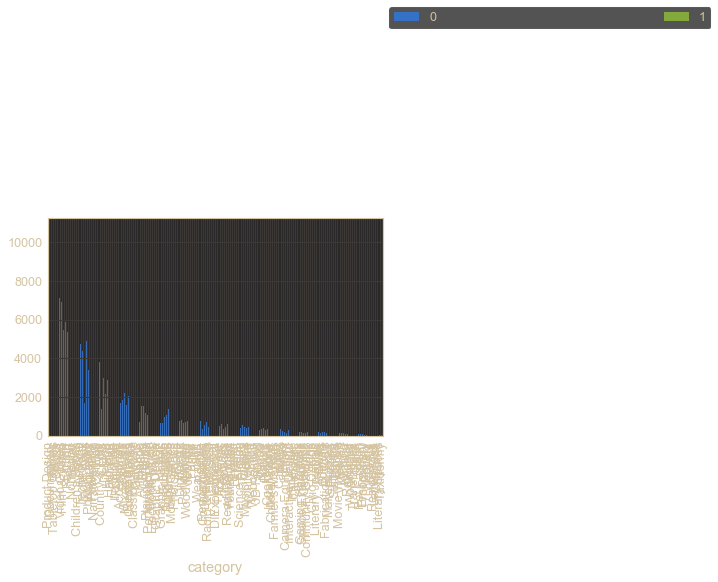

state,0,1
main_category,,
Film & Video,32592,23618
Music,21713,24197
Publishing,23116,12300
Games,15949,12512
Technology,20432,6434
Art,14090,11510
Design,14763,10550
Food,15914,6085
Fashion,14167,5593


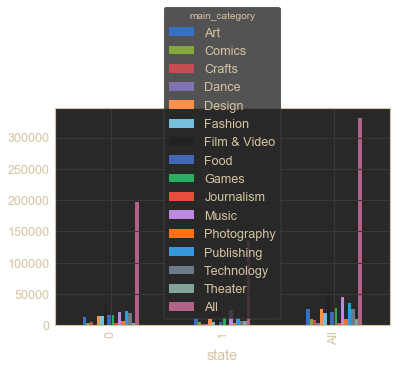

<Figure size 1080x720 with 0 Axes>

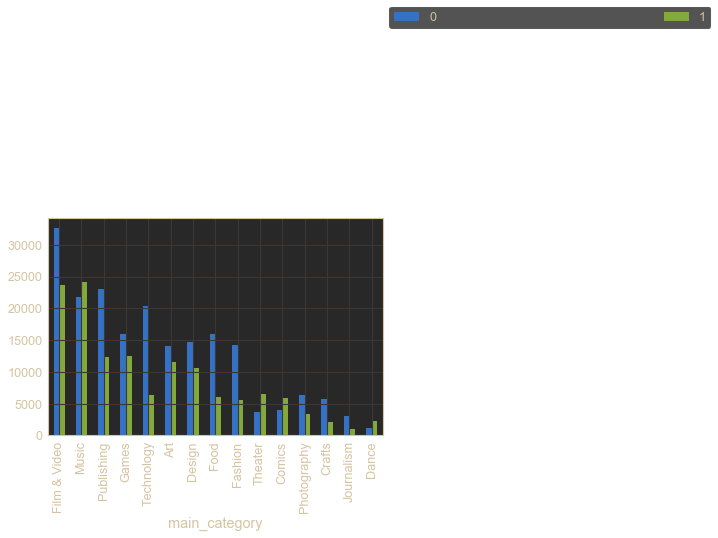

state,0,1
currency,,
USD,151580,109369
GBP,17312,12080
EUR,10403,3882
CAD,8199,4137
AUD,4570,2011
SEK,993,509
MXN,1013,396
NZD,824,448
DKK,566,362


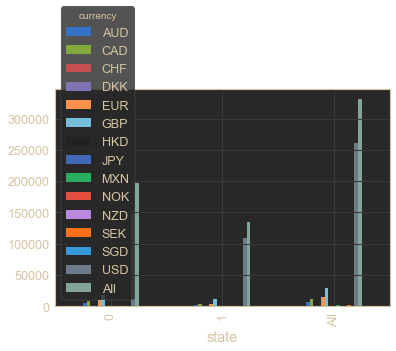

<Figure size 1080x720 with 0 Axes>

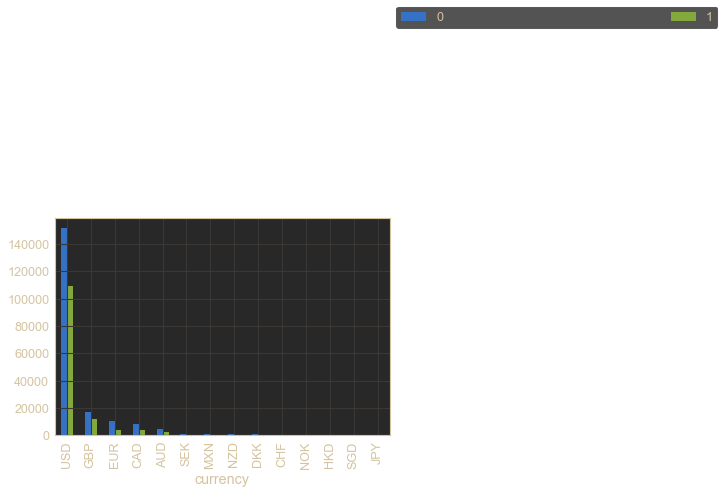

state,0,1
country,,
US,151511,109289
GB,17304,12066
CA,8197,4134
AU,4566,2010
DE,2474,937
FR,1597,908
NL,1781,617
IT,1914,439
ES,1369,492


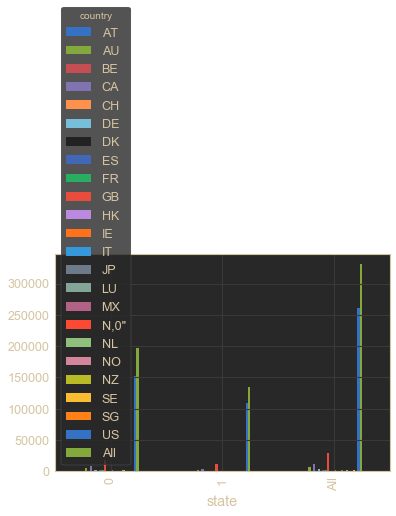

<Figure size 1080x720 with 0 Axes>

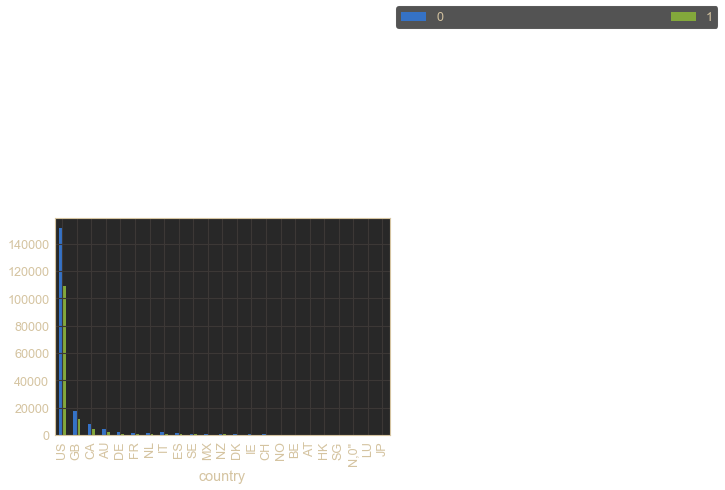

In [11]:
#質的変数のみの表示
for col in df_ks.columns:
    if col=="state"or col=="usd_goal_real"or col=="deadline"or col=="launched"or col=="delta":
        continue
    #クロス集計分析.カテゴリごとのstate集計
    df_cross = pd.crosstab(index=[df_ks["state"]], columns=df_ks[col],margins=True)
    df_cross.plot.bar()
    df_cross_show = df_cross.T.sort_values(by=['All'], ascending=False)
    df_cross_show = df_cross_show.drop(columns=['All'])
    df_cross_show = df_cross_show.drop('All')
    display(df_cross_show)
    plt.figure(figsize=(15, 10))
    df_cross_show.plot.bar()
    #凡例の位置変えたい
    plt.legend(bbox_to_anchor=(1, 1, 1, 1),ncol=2,mode="expand")

    plt.show()

In [12]:
#質的変数をダミー変数へ
#category含めると時間かかるので除外
#use_col = ["category","main_category","country", "currency"]
use_col = ["main_category","country", "currency"]
df_ks = df_ks.drop(columns=['category'])

dum_ks = pd.get_dummies(df_ks[use_col]) 
display(dum_ks.head())
display(dum_ks.tail())
np.savetxt('kickstarter_project/dumksprojects-201801.csv',dum_ks, delimiter=',')

# ダミー変数へ変換後のデータセットキーの確認
#print(dum_ks.keys())

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
378654,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
378657,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378658,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378660,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# ダミー変数へ変換後のデータフレームに更新
df_ks = pd.concat([df_ks, dum_ks], axis=1)
df_ks = df_ks.drop(columns=['main_category', 'country', 'currency'])
#df_ks = df_ks.drop(columns=['category','main_category', 'country', 'currency'])
df_ks.head()

,state,usd_goal_real,launched,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,1533.95,2015,58,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,30000.00,2017,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,2013,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,2012,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,2016,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# ダミー変数へ変換後のデータセットキーの確認
#print(df_ks.describe())
print(df_ks.keys())

Index(['state', 'usd_goal_real', 'launched', 'delta', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US',
       'currency_AUD', 'currency_CAD', 'currency_CHF', 'currency_DKK',
       'currency_EUR', 'currency_GBP', 'currency_HKD', 'currency_JPY',
       'currency_MXN', 'cu

## 特徴選択
特徴選択を行って無駄な説明変数を減らす。フィルタ法、ラッパー法、埋め込み法などがある。  
今回は精度を上げたいのでラッパー法を選択したが想像以上に時間がかかって10分経っても終わらないのでLASSOによる特徴選択を行う。  
その前にフィルタ法で相関係数が1に近いcountryとcurrencyの組み合わせを削除。

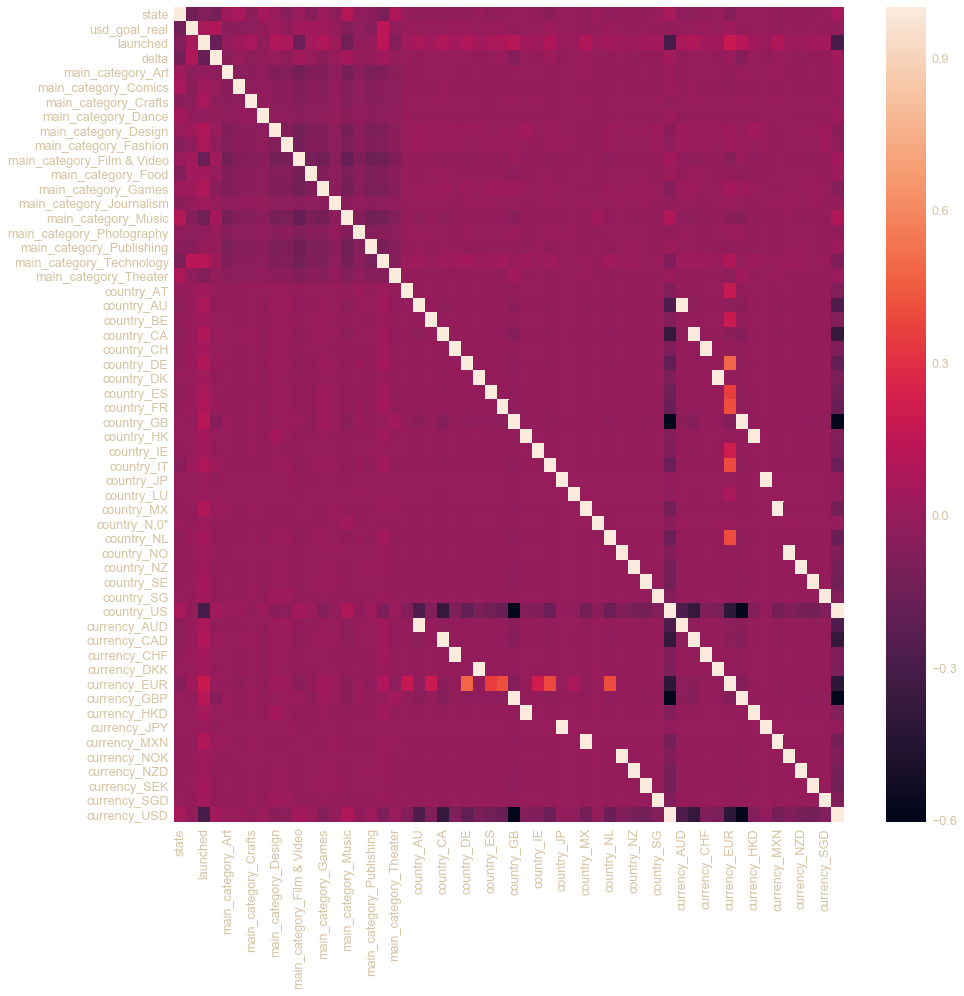

In [15]:
df_ks.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_ks.corr())
plt.savefig('kickstarter_project/seaborn_heatmap_big.png')
plt.show()

In [16]:
#不要な特徴削除
df_ks = df_ks.drop(columns=['country_AU', 'country_CH', 'country_CA',
        'country_DK', 'country_GB', 'country_HK','country_JP', 'country_MX',
        'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US',])

In [17]:
# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は分類なのでaccuracyを評価指標に指定
clf2 = SGDClassifier(loss='log', penalty='l1', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
rfecv = RFECV(clf2, cv=5, scoring='accuracy')

y = df_ks["state"].values
X = df_ks.drop("state", axis=1)
# 標準化
stdsc = StandardScaler()
X_stand = stdsc.fit_transform(X)

In [18]:
# #ラッパー法
# # fitで特徴選択を実行
# rfecv.fit(X_stand, y)
# # 特徴のランキングを表示（1が最も重要な特徴）
# print('Feature ranking: \n{}'.format(rfecv.ranking_))

In [19]:
# # 特徴数とスコアの変化をプロット
# # 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()
# # rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# # Trueになっている特徴を使用すれば汎化誤差は最小となる
# print(rfecv.support_)
# # bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# # ここでTrueになっている特徴が削除してもよい特徴
# remove_idx = ~rfecv.support_
# print(remove_idx)
# # 削除してもよい特徴の名前を取得する
# remove_feature = df_ks.columns[remove_idx]
# print(remove_feature)
# # drop関数で特徴を削除
# selected_df_ks = df_ks.drop(remove_feature, axis=1)
# print(selected_df_ks.head())

In [20]:
#埋め込み法、LASSO
sfm = SelectFromModel(clf2, threshold=1e-5)
# fitで特徴選択を実行
sfm.fit(X_stand, y)
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()
print(sfm.get_support())
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
print(X.columns[removed_idx])
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
print(abs_coef)

[ True  True  True False  True  True  True  True  True False  True  True
  True  True  True  True  True  True False False False False  True False
  True False False  True False  True False  True  True  True  True False
  True False False  True False False]
Index(['main_category_Art', 'main_category_Film & Video', 'country_AT',
       'country_BE', 'country_DE', 'country_ES', 'country_IE', 'country_LU',
       'country_N,0"', 'currency_AUD', 'currency_CHF', 'currency_JPY',
       'currency_NOK', 'currency_NZD', 'currency_SGD', 'currency_USD'],
      dtype='object')
[[0.87006675 0.04374244 0.27172831 0.         0.105975   0.12124833
  0.06241466 0.01515624 0.20037819 0.         0.13066882 0.04811957
  0.11922639 0.17132302 0.02764282 0.16132417 0.13438543 0.07351011
  0.         0.         0.         0.         0.06666796 0.
  0.03078981 0.         0.         0.01516351 0.         0.05673756
  0.         0.03716963 0.06313061 0.01444984 0.01374495 0.
  0.04324253 0.         0.         0.

In [21]:
# Abs_coef = abs_coef.value
# #print(Abs_coef.shape)
# #print(Abs_coef.dtype)
# # 係数を棒グラフで表示.えらーでる
# plt.barh(np.arange(0, len(Abs_coef)), Abs_coef, tick_label=X.columns.values)
# plt.show()

In [22]:
#不要な特徴削除
df_ks = df_ks.drop(columns=['main_category_Art', 'main_category_Design', 'country_BE', 'country_DE',
       'country_FR', 'country_IT', 'country_LU', 'country_N,0"', 'country_NL',
       'currency_DKK', 'currency_HKD', 'currency_JPY', 'currency_NOK',
       'currency_NZD'])


In [23]:
print(df_ks.keys())
feature_names = ['usd_goal_real', 'launched', 'delta', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_ES', 'country_IE',
       'currency_AUD', 'currency_CAD', 'currency_CHF', 'currency_EUR',
       'currency_GBP', 'currency_MXN', 'currency_SEK', 'currency_SGD',
       'currency_USD']

Index(['state', 'usd_goal_real', 'launched', 'delta', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_ES', 'country_IE',
       'currency_AUD', 'currency_CAD', 'currency_CHF', 'currency_EUR',
       'currency_GBP', 'currency_MXN', 'currency_SEK', 'currency_SGD',
       'currency_USD'],
      dtype='object')


In [40]:
#特徴選択+標準化+ロジスティック回帰+L1正則化した時のホールドアウト法の汎化誤差
y = df_ks["state"].values
X = df_ks.drop("state", axis=1)
#　ホールドアウト法
# 全データのうち、何%をテストデータにするか（今回は20%に設定
test_size = 0.2  
# テストデータはランダム選択
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
# 標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
X_test_stand = stdsc.transform(X_test)
# 学習用データを使ってL1正則化ロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='l1', alpha=0.00009, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

w0 = -0.553, w1 = -0.803, w2 = -0.090
訓練誤差
対数尤度 = -12.365
正答率（Accuracy） = 64.200%
適合率（Precision） = 65.259%
再現率（Recall） = 85.314%
F1値（F1-score） = 73.951%
汎化誤差
対数尤度 = -12.372
正答率（Accuracy） = 64.180%
適合率（Precision） = 65.144%
再現率（Recall） = 85.193%
F1値（F1-score） = 73.832%


In [51]:
# 学習用データを使ってL1正則化ロジスティック回帰モデルを学習
alpha=0.0005
clf2 = SGDClassifier(loss='log', penalty='l1', alpha=alpha, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
y_pred_train = clf2.predict(X_train_stand)
print('alpha={:.5f}'.format(alpha))
print('訓練誤差 {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差 {:.3f}%'.format(100 * accuracy))

alpha=0.00050
訓練誤差 64.180%
汎化誤差 64.180%


alpha=0.1, max_iter=10000
訓練誤差 59.563%
汎化誤差 59.314%
alpha=0.01, max_iter=10000  
訓練誤差 63.711%  
汎化誤差 63.594%  
alpha=0.0001, max_iter=10000 デフォルト  
訓練誤差　64.275%  
汎化誤差　64.266  
alpha=0.00001, max_iter=1000000  
訓練誤差 63.983%  
汎化誤差 63.834%  
alpha=0.000001, max_iter=10000000  
訓練誤差 61.693%  
汎化誤差 61.464%  

alpha=0.00007  
訓練誤差 64.180%  
汎化誤差 64.180%  
alpha=0.00008  
訓練誤差 64.180%  
汎化誤差 64.180%  
alpha=0.00009  
訓練誤差 64.200%  
汎化誤差 64.180%  
alpha=0.0002  
訓練誤差 64.380%  
汎化誤差 64.242%  
alpha=0.0003  
訓練誤差 64.514%  
汎化誤差 64.426%  
alpha=0.0004  
訓練誤差 64.571%  
汎化誤差 64.386%  
alpha=0.0005  
訓練誤差 66.461%  
汎化誤差 64.399%  


In [25]:
#特徴選択+標準化+ロジスティック回帰+L2正則化した時のホールドアウト法の汎化誤差
clf2 = SGDClassifier(loss='log', penalty='l2', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

w0 = -0.464, w1 = -0.822, w2 = -0.136
訓練誤差
対数尤度 = -12.385
正答率（Accuracy） = 64.143%
適合率（Precision） = 66.640%
再現率（Recall） = 79.695%
F1値（F1-score） = 72.585%
汎化誤差
対数尤度 = -12.454
正答率（Accuracy） = 63.943%
適合率（Precision） = 66.436%
再現率（Recall） = 79.244%
F1値（F1-score） = 72.277%


L1正則化L2正則化ともに精度は上がらなかった。

## 木モデル
決定木、ランダムフォレスト、アダブースト

In [29]:
#特徴選択+標準化+ロジスティック回帰+L1正則化した時のホールドアウト法の汎化誤差
y = df_ks["state"].values
X = df_ks.drop("state", axis=1)
#　ホールドアウト法
# 全データのうち、何%をテストデータにするか（今回は20%に設定
test_size = 0.2  
# テストデータはランダム選択
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
# 標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
X_test_stand = stdsc.transform(X_test)
# 学習用データを使って決定木モデルを学習
clf2 = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=100, random_state=1234)
clf2.fit(X_train_stand, y_train)
print("score=", clf2.score(X_train_stand, y_train))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

score= 0.6772981699129464
訓練誤差
対数尤度 = -11.146
正答率（Accuracy） = 67.730%
適合率（Precision） = 69.944%
再現率（Recall） = 80.270%
F1値（F1-score） = 74.752%
汎化誤差
対数尤度 = -11.490
正答率（Accuracy） = 66.733%
適合率（Precision） = 69.381%
再現率（Recall） = 79.485%
F1値（F1-score） = 74.090%


min_samples_leafが数個だと過学習が強い。  
ロジスティック回帰の64%に比べると精度は上昇した。

[4.34509398e-01 9.64253627e-02 2.23214343e-01 2.63420945e-02
 1.18802805e-02 9.28894221e-03 2.28783364e-02 1.37610142e-02
 1.04428119e-02 1.68599515e-02 4.29578740e-03 3.28287631e-02
 7.81332761e-03 2.00409241e-02 2.00826608e-02 2.98181567e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.53342953e-04
 2.10812958e-04 0.00000000e+00 1.07099725e-03 5.63348074e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24492106e-02]


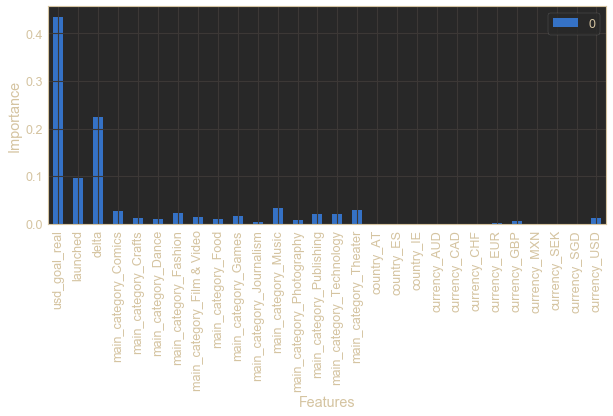

In [30]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf2.feature_importances_)
pd.DataFrame(clf2.feature_importances_, index=feature_names).plot.bar(figsize=(10,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [31]:
# 時間かかって終わらない
# # 決定木の描画
# dot_data = StringIO() #dotファイル情報の格納先
# export_graphviz(clf2, out_file=dot_data,  
#                      feature_names=feature_names,  
#                      class_names=["state"],  
#                      filled=True, rounded=True,  
#                      special_characters=True) 
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

決定木の描写が上手くいかなかった。次はランダムフォレストによる予測を行う

score= 0.6701090810337804
訓練誤差
対数尤度 = -11.394
正答率（Accuracy） = 67.011%
適合率（Precision） = 68.581%
再現率（Recall） = 82.252%
F1値（F1-score） = 74.797%
汎化誤差
対数尤度 = -11.392
正答率（Accuracy） = 67.016%
適合率（Precision） = 68.738%
再現率（Recall） = 82.321%
F1値（F1-score） = 74.919%
[3.65466818e-01 1.01195950e-01 2.11450211e-01 2.93596114e-02
 1.55633113e-02 1.12106908e-02 3.51827328e-02 9.07667861e-03
 2.59022230e-02 1.51687687e-02 7.30369527e-03 3.75546914e-02
 7.99995146e-03 2.29584629e-02 5.00110276e-02 3.40750134e-02
 0.00000000e+00 6.42487912e-05 0.00000000e+00 1.42980681e-03
 1.54633485e-03 0.00000000e+00 4.46433522e-03 4.15506367e-03
 3.74890574e-04 3.42856308e-05 0.00000000e+00 8.45119658e-03]


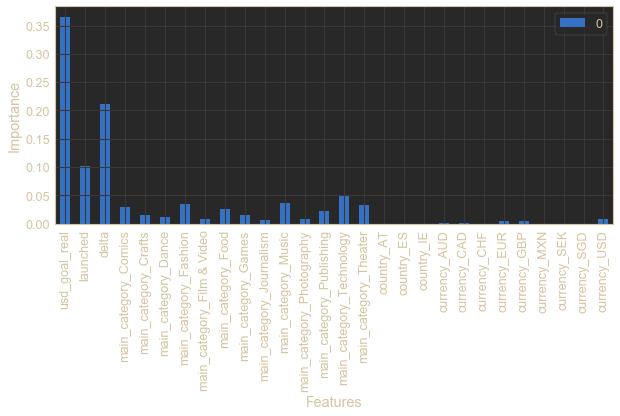

In [32]:
clf2 = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=100, random_state=1234)
clf2.fit(X_train_stand, y_train)
print("score=", clf2.score(X_train_stand, y_train))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf2.feature_importances_)
pd.DataFrame(clf2.feature_importances_, index=feature_names).plot.bar(figsize=(10,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

決定木はランダムフォレストより訓練誤差は0.6%高かった。  
しかし汎化誤差はランダムフォレストの方が0.5%ほど精度が良かった。  
次はアダブースト+決定木で予測を行う。

score= 0.7122629411143465
訓練誤差
対数尤度 = -9.938
正答率（Accuracy） = 71.226%
適合率（Precision） = 73.230%
再現率（Recall） = 81.414%
F1値（F1-score） = 77.105%
汎化誤差
対数尤度 = -11.958
正答率（Accuracy） = 65.378%
適合率（Precision） = 69.003%
再現率（Recall） = 76.515%
F1値（F1-score） = 72.565%
[5.11150675e-01 1.24457535e-01 1.97886524e-01 5.18647378e-03
 3.42630460e-03 3.09171930e-03 6.94415391e-03 2.21973870e-02
 9.19267203e-03 1.25099641e-02 4.04342971e-03 1.70027293e-02
 3.99622289e-03 1.28659434e-02 1.21304177e-02 6.90599005e-03
 3.84329574e-04 7.75633271e-04 3.34555769e-04 2.30399031e-03
 4.54305846e-03 3.61619665e-04 7.09125645e-03 8.37271857e-03
 1.75014890e-03 4.05878813e-04 1.72063274e-04 2.05166057e-02]


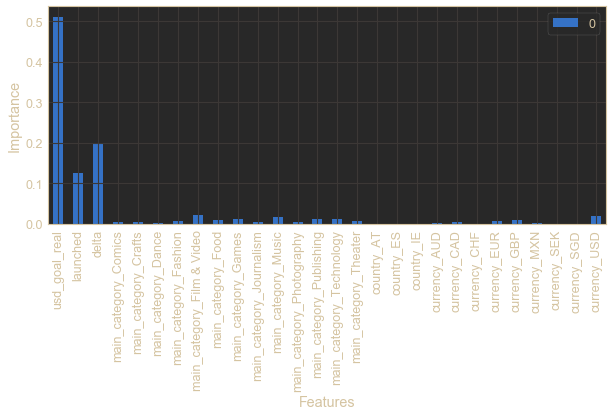

In [33]:
clf2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,min_samples_leaf=100, 
                                                 random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf2.fit(X_train_stand, y_train)
print("score=", clf2.score(X_train_stand, y_train))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf2.feature_importances_)
pd.DataFrame(clf2.feature_importances_, index=feature_names).plot.bar(figsize=(10,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

決定木  
訓練誤差  
対数尤度 = -11.155  
正答率（Accuracy） = 67.704%  
適合率（Precision） = 69.998%  
再現率（Recall） = 80.087%  
F1値（F1-score） = 74.703%  
汎化誤差  
対数尤度 = -11.558  
正答率（Accuracy） = 66.535%  
適合率（Precision） = 69.311%  
再現率（Recall） = 79.181%  
F1値（F1-score） = 73.918%  

RF  
score= 0.6707469661566292  
訓練誤差  
対数尤度 = -11.372  
正答率（Accuracy） = 67.075%  
適合率（Precision） = 68.598%  
再現率（Recall） = 82.441%  
F1値（F1-score） = 74.886%  
汎化誤差  
対数尤度 = -11.389  
正答率（Accuracy） = 67.025%  
適合率（Precision） = 68.834%  
再現率（Recall） = 82.123%  
F1値（F1-score） = 74.894%  

決定木+アダブースト  
score= 0.7138652295168463  
訓練誤差  
対数尤度 = -9.883  
正答率（Accuracy） = 71.387%  
適合率（Precision） = 73.438%  
再現率（Recall） = 81.380%  
F1値（F1-score） = 77.205%  
汎化誤差  
対数尤度 = -11.889  
正答率（Accuracy） = 65.578%  
適合率（Precision） = 69.252%  
再現率（Recall） = 76.483%  
F1値（F1-score） = 72.688%  

## ニューラルネットワーク

In [34]:
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=28))
model.add(Dense(4, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
#lrは学習率
#momentumは慣性項のパラメータであり、前回の更新量にα倍して加算することで
#パラメータの更新をより慣性的なものにする
#nesterovは慣性項をそのままに、更新の起点の位置を更新後の点にしている
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
# 計算の実行
fit = model.fit(X_train_stand, y_train, epochs=10,batch_size=20,
                validation_data=(X_test_stand, y_test))

Train on 265124 samples, validate on 66281 samples
Epoch 1/10
265124/265124 [==============================] - 27s 101us/sample - loss: 0.6354 - acc: 0.6365 - val_loss: 0.6265 - val_acc: 0.6490
Epoch 2/10
265124/265124 [==============================] - 27s 100us/sample - loss: 0.6278 - acc: 0.6444 - val_loss: 0.6248 - val_acc: 0.6533
Epoch 3/10
265124/265124 [==============================] - 27s 100us/sample - loss: 0.6256 - acc: 0.6482 - val_loss: 0.6212 - val_acc: 0.6546
Epoch 4/10
265124/265124 [==============================] - 26s 100us/sample - loss: 0.6242 - acc: 0.6484 - val_loss: 0.6207 - val_acc: 0.6520
Epoch 5/10
265124/265124 [==============================] - 27s 101us/sample - loss: 0.6234 - acc: 0.6484 - val_loss: 0.6204 - val_acc: 0.6532
Epoch 6/10
265124/265124 [==============================] - 27s 100us/sample - loss: 0.6231 - acc: 0.6495 - val_loss: 0.6227 - val_acc: 0.6478
Epoch 7/10
265124/265124 [==============================] - 27s 101us/sample - loss: 0.6229

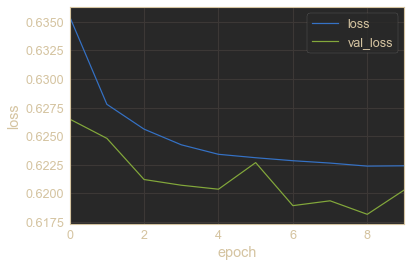

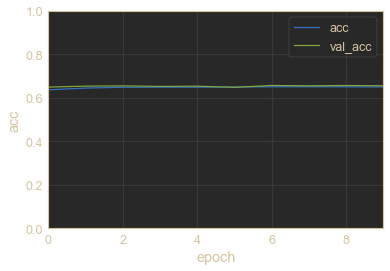

In [36]:
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [37]:
#計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()

weights[0]=
[[ 5.58597922e-01  7.43278980e-01  1.60785067e+00  6.61260700e+00
  -5.43502450e-01  1.60348737e+00]
 [ 1.10313022e+00  2.54434776e+00  6.85468674e-01  2.07346261e-01
  -7.53901899e-01  9.12800252e-01]
 [ 9.78655100e-01 -2.90839434e-01 -6.50150061e-01  2.95060307e-01
  -4.61649224e-02  5.74938536e-01]
 [ 2.90841639e-01  1.82990327e-01 -3.89717728e-01 -1.73159122e-01
   2.05922663e-01 -2.56728262e-01]
 [ 4.20430362e-01  1.33772120e-01 -3.53306174e-01  1.12375289e-01
  -8.54046047e-02  3.35238010e-01]
 [ 5.00380844e-02 -3.63674700e-01 -2.38712460e-01 -1.87005207e-01
  -5.35319708e-02 -2.16232598e-01]
 [ 8.98238480e-01 -2.17296273e-01  2.23590836e-01  8.30784217e-02
   3.95900577e-01  3.35515082e-01]
 [ 7.16827214e-01 -1.66240022e-01 -1.57647014e-01 -1.89091310e-01
   2.60534883e-01  1.88032985e-01]
 [-4.08620000e-01 -1.08024448e-01 -1.09225176e-01 -6.85466230e-01
  -3.85111779e-01  1.18357921e+00]
 [ 3.47437441e-01 -7.59407133e-02 -5.02012491e-01 -8.49844515e-02
   4.32049960

In [38]:
# 保存
model.save('kickstarter_project/my_model.h5')
del model
# 読み込み
model = load_model('kickstarter_project/my_model.h5')
# WARNINGが出るが気にしなくて良い
y_pred_test = np.argmax(model.predict(X_test_stand),axis=1)
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
正答率（Accuracy） = 65.498%


Train on 265124 samples, validate on 66281 samples
Epoch 1/10
265124/265124 [==============================] - 30s 112us/sample - loss: 0.6314 - acc: 0.6459 - val_loss: 0.6266 - val_acc: 0.6493
Epoch 2/10
265124/265124 [==============================] - 29s 109us/sample - loss: 0.6309 - acc: 0.6466 - val_loss: 0.6369 - val_acc: 0.6485
Epoch 3/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6312 - acc: 0.6471 - val_loss: 0.6282 - val_acc: 0.6495
Epoch 4/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6319 - acc: 0.6477 - val_loss: 0.6311 - val_acc: 0.6446
Epoch 5/10
265124/265124 [==============================] - 28s 106us/sample - loss: 0.6321 - acc: 0.6462 - val_loss: 0.6398 - val_acc: 0.6016
Epoch 6/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6325 - acc: 0.6466 - val_loss: 0.6337 - val_acc: 0.6504
Epoch 7/10
265124/265124 [==============================] - 29s 109us/sample - loss: 0.6336

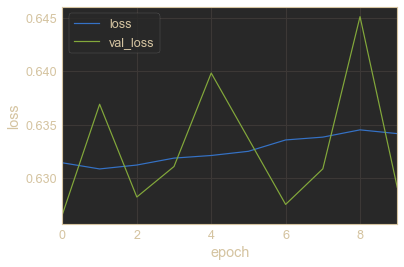

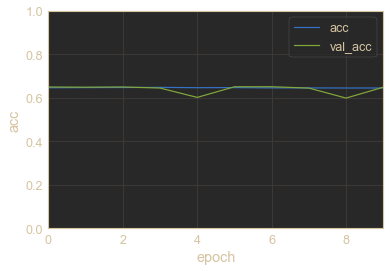

weights[0]=
[[ 13.354023   -47.065598     7.1713758   39.46977     18.38726
  -57.86249   ]
 [  1.7722396   21.686857     4.0931296   -0.82203764   0.18617351
   -9.770352  ]
 [  3.421702   -14.288007     2.261006     1.7256992    8.273664
   -7.3269534 ]
 [  8.021356   -10.045555    -2.6589646   -1.461609     0.5516159
  -10.995231  ]
 [  5.617293   -16.34353      1.0972409    1.6158683    6.6033845
  -17.559557  ]
 [  4.900634    -7.3467455   -1.3793857   -8.09631      1.1785326
    4.5699334 ]
 [  8.257971   -25.13741      0.23879737   0.59150666   5.3474092
  -28.973066  ]
 [ 11.733878   -25.491861    -0.25279662  -2.3473983    5.260137
  -37.337105  ]
 [  6.664507   -25.820911    -0.93427193   0.72542393   7.789688
  -27.184694  ]
 [ 10.100655   -20.115309    -6.336902    -1.1838683    3.070391
  -27.085924  ]
 [  3.6330833  -12.041132     2.3511555    2.9922493    4.1782727
  -12.924364  ]
 [ 12.789925   -23.998434    -1.1098931   -2.6774821    1.756437
  -33.36131   ]
 [  6.4411

In [40]:
#rmsを使って最適化する
rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])
# 計算の実行
fit = model.fit(X_train_stand, y_train, epochs=10,batch_size=20,
                validation_data=(X_test_stand, y_test))
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
#計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()
# 保存
model.save('kickstarter_project/my_model_2.h5')
del model
# 読み込み
model = load_model('kickstarter_project/my_model_2.h5')
# WARNINGが出るが気にしなくて良い
y_pred_test = np.argmax(model.predict(X_test_stand),axis=1)
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

Train on 265124 samples, validate on 66281 samples
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
265124/265124 [==============================] - 28s 107us/sample - loss: 0.6263 - acc: 0.6494 - val_loss: 0.6245 - val_acc: 0.6516
Epoch 2/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6253 - acc: 0.6500 - val_loss: 0.6242 - val_acc: 0.6521
Epoch 3/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6250 - acc: 0.6502 - val_loss: 0.6240 - val_acc: 0.6521
Epoch 4/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6248 - acc: 0.6503 - val_loss: 0.6239 - val_acc: 0.6523
Epoch 5/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6247 - acc: 0.6507 - val_loss: 0.6238 - val_acc: 0.6525
Epoch 6/10
265124/265124 [==============================] - 28s 106us/sample - loss: 0.6246 - acc: 0.6510 - val_loss

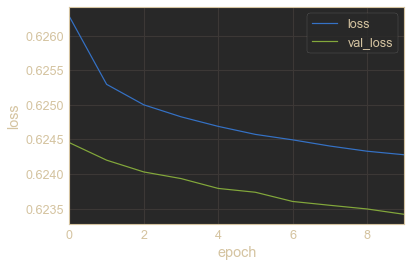

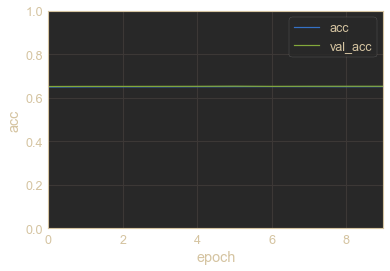

weights[0]=
[[ 13.3808975  -47.102703     7.2054825   39.68167     18.433853
  -57.953114  ]
 [  1.6841909   21.816025     4.148609    -0.795896     0.21469851
   -9.926441  ]
 [  3.4315062  -14.391234     2.101044     1.463761     8.3118
   -7.2301598 ]
 [  7.962406    -9.995847    -2.630877    -1.2560254    0.50743854
  -11.058591  ]
 [  5.603118   -16.266348     1.1084771    1.5495211    6.4520245
  -17.37187   ]
 [  5.0523734   -7.3746047   -1.3497806   -8.039532     1.2191639
    4.374126  ]
 [  8.22907    -25.106625     0.2766909    0.59187233   5.428925
  -28.917145  ]
 [ 11.710132   -25.501986    -0.14003347  -2.1561267    5.237142
  -37.411453  ]
 [  6.6128     -25.808334    -0.89209455   0.85574      7.829241
  -27.146004  ]
 [ 10.127551   -20.066347    -6.2952995   -1.2472781    3.0324037
  -27.079155  ]
 [  3.6398926  -12.032011     2.3405046    2.8809998    4.028599
  -12.723561  ]
 [ 12.727337   -24.049469    -1.1165229   -2.910425     1.6332968
  -33.408543  ]
 [  6.4288

In [41]:
#adagを使って最適化する
adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adag,
              metrics=['accuracy'])
# 計算の実行
fit = model.fit(X_train_stand, y_train, epochs=10,batch_size=20,
                validation_data=(X_test_stand, y_test))
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
#計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()
# 保存
model.save('kickstarter_project/my_model_3.h5')
del model
# 読み込み
model = load_model('kickstarter_project/my_model_3.h5')
# WARNINGが出るが気にしなくて良い
y_pred_test = np.argmax(model.predict(X_test_stand),axis=1)
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

Train on 265124 samples, validate on 66281 samples
Epoch 1/10
265124/265124 [==============================] - 29s 108us/sample - loss: 0.6242 - acc: 0.6510 - val_loss: 0.6234 - val_acc: 0.6527
Epoch 2/10
265124/265124 [==============================] - 28s 106us/sample - loss: 0.6242 - acc: 0.6511 - val_loss: 0.6234 - val_acc: 0.6527
Epoch 3/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6243 - acc: 0.6511 - val_loss: 0.6235 - val_acc: 0.6527
Epoch 4/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6243 - acc: 0.6511 - val_loss: 0.6234 - val_acc: 0.6528
Epoch 5/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6242 - acc: 0.6511 - val_loss: 0.6234 - val_acc: 0.6527
Epoch 6/10
265124/265124 [==============================] - 28s 105us/sample - loss: 0.6242 - acc: 0.6511 - val_loss: 0.6234 - val_acc: 0.6527
Epoch 7/10
265124/265124 [==============================] - 28s 104us/sample - loss: 0.6242

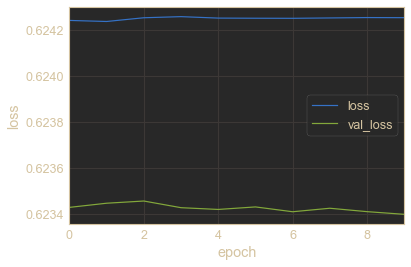

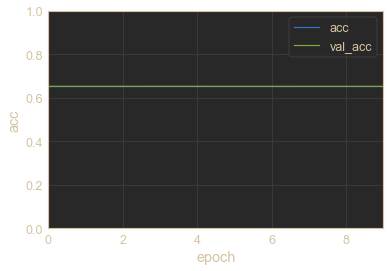

weights[0]=
[[ 13.362399   -47.132645     7.203568    39.707653    18.44184
  -57.96693   ]
 [  1.6789924   21.839184     4.164725    -0.8034786    0.21796781
   -9.932768  ]
 [  3.4214637  -14.415042     2.0779946    1.423856     8.321555
   -7.234226  ]
 [  7.956622    -9.993185    -2.6330934   -1.2443508    0.5073859
  -11.063588  ]
 [  5.5945325  -16.280926     1.100823     1.527086     6.44169
  -17.381962  ]
 [  5.042941    -7.382935    -1.3505454   -8.041799     1.2181773
    4.3514996 ]
 [  8.219372   -25.12349      0.27226013   0.5786671    5.436742
  -28.933449  ]
 [ 11.710097   -25.515293    -0.12293945  -2.1302094    5.2453027
  -37.43612   ]
 [  6.6034846  -25.818436    -0.8943818    0.85955083   7.8438215
  -27.17364   ]
 [ 10.123887   -20.0733      -6.3013396   -1.2430243    3.0370991
  -27.09396   ]
 [  3.6328988  -12.036322     2.3274343    2.867139     4.0286427
  -12.7295885 ]
 [ 12.716584   -24.065817    -1.0913045   -2.913061     1.6279131
  -33.43402   ]
 [  6.419

In [42]:
#adadを使って最適化する
adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adad,
              metrics=['accuracy'])
# 計算の実行
fit = model.fit(X_train_stand, y_train, epochs=10,batch_size=20,
                validation_data=(X_test_stand, y_test))
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
#計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()
# 保存
model.save('kickstarter_project/my_model_4.h5')
del model
# 読み込み
model = load_model('kickstarter_project/my_model_4.h5')
# WARNINGが出るが気にしなくて良い
y_pred_test = np.argmax(model.predict(X_test_stand),axis=1)
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

Train on 265124 samples, validate on 66281 samples
Epoch 1/10
265124/265124 [==============================] - 31s 118us/sample - loss: 0.6329 - acc: 0.6428 - val_loss: 0.6330 - val_acc: 0.6477
Epoch 2/10
265124/265124 [==============================] - 31s 116us/sample - loss: 0.6375 - acc: 0.6425 - val_loss: 0.6316 - val_acc: 0.6481
Epoch 3/10
265124/265124 [==============================] - 31s 116us/sample - loss: 0.6360 - acc: 0.6436 - val_loss: 0.6284 - val_acc: 0.6466
Epoch 4/10
265124/265124 [==============================] - 31s 116us/sample - loss: 0.6339 - acc: 0.6439 - val_loss: 0.6354 - val_acc: 0.6400
Epoch 5/10
265124/265124 [==============================] - 31s 116us/sample - loss: 0.6329 - acc: 0.6444 - val_loss: 0.6265 - val_acc: 0.6506
Epoch 6/10
265124/265124 [==============================] - 31s 115us/sample - loss: 0.6317 - acc: 0.6440 - val_loss: 0.6259 - val_acc: 0.6507
Epoch 7/10
265124/265124 [==============================] - 31s 117us/sample - loss: 0.6313

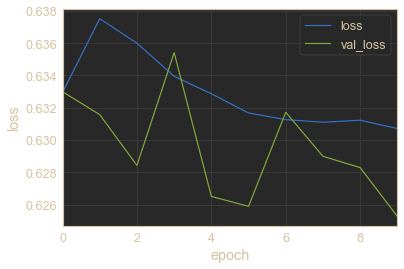

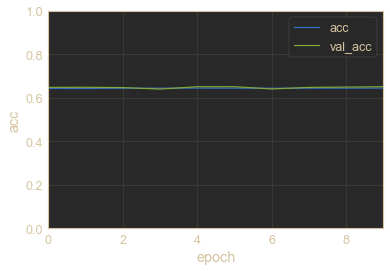

weights[0]=
[[ 20.185719   -12.718388    -3.0866868   41.66671     32.96644
  -54.879963  ]
 [  3.8518703   -3.9571471    2.8961105   -1.8256383    5.743555
   -9.969318  ]
 [  6.393918    -0.56972885   1.0266038    1.9038115    7.616354
    0.54116243]
 [  8.640392   -10.576027    -2.0963366   -1.219821     4.484265
   -9.52043   ]
 [  7.627958    -3.0079403    0.1710468    0.6359757    6.963367
   -4.489502  ]
 [  4.5072145   -1.9874767   -1.22572     -9.535315     4.9611735
   -3.1821024 ]
 [ 12.9666395  -10.77827     -0.09032256   0.64373654   6.5916677
  -16.885118  ]
 [ 15.509857   -22.142168    -0.61091     -2.0476897   15.050474
  -15.790827  ]
 [  9.205886    -7.6034737   -0.12521653   0.89790726  11.10924
   -6.623586  ]
 [ 14.961596   -14.690966    -5.4791455   -1.2626336    6.1038303
  -16.788418  ]
 [  5.3919554   -2.5486455   -0.05542834   0.71589553   5.7103014
   -2.6711144 ]
 [ 13.130036   -19.29247     -0.9471429   -2.4209242    9.084819
  -11.4330635 ]
 [  6.7065067 

In [43]:
#adadを使って最適化する
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
# 計算の実行
fit = model.fit(X_train_stand, y_train, epochs=10,batch_size=20,
                validation_data=(X_test_stand, y_test))
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
#計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()
# 保存
model.save('kickstarter_project/my_model_5.h5')
del model
# 読み込み
model = load_model('kickstarter_project/my_model_5.h5')
# WARNINGが出るが気にしなくて良い
y_pred_test = np.argmax(model.predict(X_test_stand),axis=1)
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

## Day3ここまで

In [ ]:
#ロジスティック回帰

y = df_ks["state"].values
#X = df_ks[["usd pledged","usd_goal_real", "delta"]].values
X = df_ks.drop("state", axis=1)
clf = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
np.set_printoptions(precision=2)
#print("w = {:.3f}".format(clf.coef_)
print(clf.coef_)


In [ ]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

In [ ]:
# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「state=1」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

In [ ]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

Day1の内容のみだと  
対数尤度 = -16.468  
正答率 = 52.321%  
適合率（Precision） = 76.687%  
再現率（Recall） = 28.762%  
F1値（F1-score） = 41.834%  

## DAY2
### 標準化, ホールドアウト法

In [ ]:
#　ホールドアウト法
# 全データのうち、何%をテストデータにするか（今回は20%に設定
test_size = 0.2      
# テストデータはランダム選択
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [ ]:
# ホールドアウト法実行
clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

# train用データに対する予測を実行
y_pred_train = clf2.predict(X_train)

# 対数尤度を表示
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))

# 正答率を計算
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)

# カテゴリ「state=1」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# test用データに対する予測を実行
y_pred_test = clf2.predict(X_test)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

In [ ]:
# 標準化
#print(X_train.dtypes)
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
plt.hist(X_train_stand[:, 1]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
X_test_stand = stdsc.transform(X_test)
plt.hist(X_test_stand[:, 1]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

In [ ]:
# 標準化したデータでホールドアウト法実行
clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

標準化した後、ホールドアウト法による訓練誤差(Accuracy)は61.086%から64.439%に改善。  
汎化誤差(Accuracy)は61.167%から64.810%に改善。汎化誤差の方がAccuracy良くなった。

### 過学習への対処
過学習を抑えるため正則化を行い最も過学習を抑えられたものを使う。  
L2正則化、L1正則化、ElasticNetの順でやってみる。  
SGDClassifierではデフォルトでL2.今まではnoneにしていた。ElasticNet使用時のl1のデフォルトλは0.15

In [ ]:
# 学習用データを使ってL2正則化ロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='l2', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

L2正則化によって汎化誤差(Accuracy)は64.810%から64.229%に悪化。

In [ ]:
# 学習用データを使ってL1正則化ロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='l1', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
#汎化誤差はすこし悪くなったが確かに重みが減った。

L1正則化によって汎化誤差(Accuracy)は64.810%から64.786%に。少し悪化。

In [ ]:
# 学習用データを使ってElasticNetロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='elasticnet',l1_ratio=0.5, max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
# L1とL2の中間って感じ。Accuracyは一番高い。

country_AUとcurrency_AUDのように国と通貨が同じだと相関係数が高い。
試しにオーストラリアだけ無相関化と白色化してみる。

In [ ]:
df_cocu = pd.DataFrame({'country_AU' : df_ks['country_AU'], 'currency_AUD' : df_ks['currency_AUD']})
#print(df_cocu)
cov = np.cov(df_cocu, rowvar=0)
_, S = np.linalg.eig(cov)
cocu_decorr = np.dot(S.T, df_cocu.T).T
print('相関係数: {:.3f}'.format(np.corrcoef(cocu_decorr[:, 0], cocu_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(cocu_decorr[:, 0], cocu_decorr[:, 1], 'o')
plt.show()
df['country_AU'] = cocu_decorr[:,0]
df['currency_AUD'] = cocu_decorr[:,1]

In [ ]:
#標準化+ロジスティック回帰+L1正則化+無相関化(白色化)した時のホールドアウト法の汎化誤差
y = df_ks["state"].values
X = df_ks.drop("state", axis=1)
#　ホールドアウト法
# 全データのうち、何%をテストデータにするか（今回は20%に設定
test_size = 0.2  
# テストデータはランダム選択
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
# 標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
X_test_stand = stdsc.transform(X_test)
# 学習用データを使ってL1正則化ロジスティック回帰モデルを学習
clf2 = SGDClassifier(loss='log', penalty='l1', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

汎化誤差（Accuracy)は64.786%で変わらず。

### サポートベクタマシン
標準化+無相関化+ホールドアウト法での汎化誤差

In [ ]:
C = 10
clf2 = SVC(C=C,kernel="linear")
# SVMつかって学習。
clf2.fit(X_train_stand, y_train)
w0 = clf2.intercept_[0]
w1 = clf2.coef_[0, 0]
w2 = clf2.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))
y_pred_train = clf2.predict(X_train_stand)
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
y_pred_test = clf2.predict(X_test_stand)
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

In [ ]:
#print(df_ks.head())
#欠損値がないか確認
#print(X.isnull().sum())
#print(X.notnull().sum())
#print(x.shape)
#print(type(x))
#print(type(X.dtypes))
# 交差検証法
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_accuracy = 0
split_num = 1

kf = KFold(n_splits=5, random_state=1234, shuffle=True)
kf.get_n_splits(X, y)

df_result = pd.DataFrame()

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(X, y):
    print("TRAIN:", train_idx.shape, "TEST:", test_idx.shape)
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf2.fit(X_train, y_train)
    # テストデータに対する予測を実行
    y_pred_test = clf2.predict(X_test)
    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    #後で平均を取るために加算
    cross_valid_accuracy += accuracy 
    split_num += 1
    df = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
    df_result = pd.concat([df_result, df], axis=0)

# 平均値を最終的な汎化誤差値とする
final_accuracy = cross_valid_accuracy / n_split
print('正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))


In [ ]:
# 交差検証法
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_logloss = 0
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    print(X[train_idx].isnull().sum())
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf2 = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf2.predict(X_test)
    
    # 対数尤度を表示
    logloss = - log_loss(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print('対数尤度 = {:.3f}'.format(logloss))

    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred_test)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

    
    #後で平均を取るために加算
    cross_valid_logloss += logloss
    cross_valid_accuracy += accuracy 
    cross_valid_precision += precision 
    cross_valid_recall += recall 
    cross_valid_f1_score += f1_score 
    split_num += 1

# 平均値を最終的な汎化誤差値とする
final_logloss = cross_valid_logloss / n_split
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split
print('対数尤度 = {:.3f}'.format(final_logloss))
print('正答率（Accuracy） = {:.3f}%'.format(100 * final_accuracy))
print('適合率（Precision） = {:.3f}%'.format(100 * final_precision))
print('再現率（Recall） = {:.3f}%'.format(100 * final_recall))
print('F1値（F1-score） = {:.3f}%'.format(100 * final_f1_score))
